In [3]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pylab
import mysql.connector as sql
import geopandas as gpd
from shapely.geometry import Point
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction import FeatureHasher
from feature_engine.categorical_encoders import MeanCategoricalEncoder, OneHotCategoricalEncoder
from feature_engine import missing_data_imputers as mdi
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import xgboost as xgb


import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.5f}'.format

In [ ]:
#db_connection = sql.connect(host='Samuels-MacBook-Air.local', database='realestate_AVM',
#                            user='root', password='Building9Floor')

In [ ]:
#df = pd.read_sql('SELECT * FROM properties;', con=db_connection)
#df.head()

In [4]:
raw_data = pd.read_csv('Data/house_data_details_eda.csv')
df = raw_data.copy()
df[['month', 'year']] = df[['month', 'year']].astype(str)
gdf = gpd.GeoDataFrame(df, geometry=[Point(xy) for xy in zip(df.longitude, df.latitude)])
gdf.crs = {'init': 'epsg:4326'}

In [5]:
#Only keep the Single Family Residence
gdf = gdf.loc[gdf['property_type']=='Single Family Residence']
gdf.shape

(2792, 19)

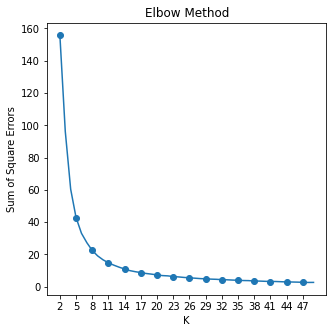

In [4]:
#Cluster the properties by location
ssd = []

for i in range(2,50):
    
    kmeans = KMeans(n_clusters=i, init ='k-means++')
    kmeans.fit_predict(gdf[['latitude', 'longitude']])
    ssd.append(ssd.append(kmeans.inertia_))
    
ssd = ssd[::2]


#Elbow method to determine the optimal number for k
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(list(range(2,50)), ssd, marker='o', markevery=3)
plt.title('Elbow Method')
plt.xlabel('K')
plt.ylabel('Sum of Square Errors')
ax.set(xticks=range(2,50,3));

In [6]:
#9 seems like the optimal number of clusters
kmeans = KMeans(n_clusters=9, init='k-means++')
gdf['geolocation_cluster'] = kmeans.fit_predict(gdf[['latitude', 'longitude']])

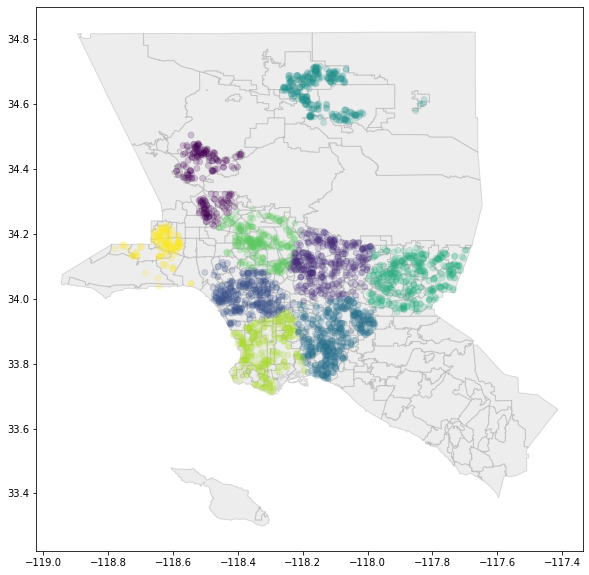

In [7]:
#Plot the data point on a map of Los Angeles
fig, ax = plt.subplots(figsize=(10,10))
#ax.set_aspect('equal')

la_full = gpd.read_file('LACounty/l.a. county neighborhood (v6).shp')
la_full.plot(ax=ax, alpha=0.4, edgecolor='darkgrey', color='lightgrey', aspect=1,zorder=1)

#Conver x_train df into geopandas df so that we can visualize it
temp_plot = gpd.GeoDataFrame(gdf.copy(), geometry=[Point(xy) for xy in zip(gdf.longitude, gdf.latitude)])
temp_plot.plot(ax=ax, aspect=1, c=temp_plot['geolocation_cluster'], alpha=0.2, linewidth=0.8, zorder=2);

In [8]:
#Find the distance between each point and each observation in order to smooth out prices that lie on the border of clusters
kc = kmeans.cluster_centers_

for i in range(len(kc)):
    gdf['distance_'+ str(i)] = np.sqrt((gdf.latitude-kc[i][0])**2+(gdf.longitude-kc[i][1])**2)
    
#Drop the latitude and longitude
gdf.drop(['latitude', 'longitude'], axis=1, inplace=True)

In [9]:
from category_encoders.hashing import HashingEncoder
he = HashingEncoder(cols=['zoning']).fit(gdf, gdf['sale_price'])
gdf = he.transform(gdf)
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2792 entries, 0 to 2791
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   col_0                  2792 non-null   int64   
 1   col_1                  2792 non-null   int64   
 2   col_2                  2792 non-null   int64   
 3   col_3                  2792 non-null   int64   
 4   col_4                  2792 non-null   int64   
 5   col_5                  2792 non-null   int64   
 6   col_6                  2792 non-null   int64   
 7   col_7                  2792 non-null   int64   
 8   property_type          2792 non-null   object  
 9   home_size              2792 non-null   float64 
 10  lot_size               2792 non-null   float64 
 11  sale_price             2792 non-null   float64 
 12  sex_offenders          2792 non-null   int64   
 13  crime_index            2792 non-null   object  
 14  enviornmental_hazards  2792 non-

In [10]:
#Split the dataset into train and test set
targets = gdf['sale_price']
inputs = gdf.drop(['sale_price', 'geometry', 'geolocation_cluster', 'month_year', 'property_type'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(inputs, targets, test_size=.2, random_state=24)

In [11]:
#Dummy encode the categorical variables
ohe_encoder = OneHotCategoricalEncoder(top_categories=7,
                                       variables=['crime_index', 'school_quality', 'month', 'year'])

ohe_encoder.fit(x_train)

x_train = ohe_encoder.transform(x_train)
x_test = ohe_encoder.transform(x_test)

In [19]:
#Optimize the objective function with hyperopt for xgboost
def acc_model(params):
    est= int(params['n_estimators'])
    lamb= int(params['reg_lambda'])
    gam= int(params['gamma'])
    depth = int(params['max_depth'])
    regressor = xgb.XGBRegressor(n_estimators=est, reg_lambda=lamb, gamma=gam, max_depth=depth)
    return cross_val_score(regressor, x_train, y_train).mean()

#Define the search space
param_space = {
    
               'n_estimators': hp.quniform('n_estimators', 25,500,1), 
               'reg_lambda': hp.quniform('reg_lambda',1,15,1), 
               'gamma': hp.quniform('gamma',1,15,1),
               'max_depth': hp.quniform('max_depth',1,10,1)
            }

best = 0

def f(params):
    global best
    acc = acc_model(params)
    if acc > best:
        best = acc
        print ('new best:', best, params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best_params = fmin(f, param_space, algo=tpe.suggest, max_evals=50, trials=trials)
print ('best:')
print (best_params)

new best:                                             
0.7818230904880303                                    
{'gamma': 2.0, 'max_depth': 3.0, 'n_estimators': 114.0, 'reg_lambda': 12.0}
new best:                                                                        
0.7840068391773714                                                               
{'gamma': 6.0, 'max_depth': 3.0, 'n_estimators': 137.0, 'reg_lambda': 10.0}      
new best:                                                                         
0.7843667640438554                                                                
{'gamma': 4.0, 'max_depth': 4.0, 'n_estimators': 51.0, 'reg_lambda': 9.0}         
new best:                                                                         
0.7852890688744978                                                                
{'gamma': 1.0, 'max_depth': 4.0, 'n_estimators': 141.0, 'reg_lambda': 6.0}        
100%|██████████| 50/50 [04:08<00:00,  4.96s/trial, best loss: -0.78528

In [23]:
est= int(best_params['n_estimators'])
lamb= int(best_params['reg_lambda'])
gam= int(best_params['gamma'])
depth = int(best_params['max_depth'])

regressor = xgb.XGBRegressor(n_estimators=est,
                             reg_lambda=lamb, 
                             gamma=gam, 
                             max_depth=depth)

regressor.fit(x_train, y_train)
predictions = regressor.predict(x_test)


# Use this code when using the log transformer
# Need to back transform the target variable

'''
predictions = np.exp(regressor.predict(x_test))
y_test = np.exp(y_test)

'''

score = np.sqrt(mean_squared_error(y_test, predictions))
print(f'XGBoost rmse score: {score}')

XGBoost rmse score: 173165.32734161103


In [33]:
#Optimize the objective function with hyperopt for Random Forest
def acc_model(params):
    est= int(params['n_estimators'])
    feat= int(params['max_features'])
    leaf= int(params['min_samples_leaf'])
    rf = RandomForestRegressor(n_estimators=est, max_features=feat, min_samples_leaf=leaf)
    return cross_val_score(rf, x_train, y_train).mean()

#Define the search space
param_space = {
    
               'n_estimators': hp.quniform('n_estimators', 25,500,1), 
               'max_features': hp.quniform('max_features',1,40,1), 
               'min_samples_leaf': hp.quniform('min_samples_leaf',1,3,1)
            }

best = 0

def f(params):
    global best
    acc = acc_model(params)
    if acc > best:
        best = acc
        print ('new best:', best, params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best_params = fmin(f, param_space, algo=tpe.suggest, max_evals=100, trials=trials)
print ('best:')
print (best_params)

new best:                                              
0.7914587038612527                                     
{'max_features': 15.0, 'min_samples_leaf': 3.0, 'n_estimators': 157.0}
new best:                                                                         
0.7948474183568888                                                                
{'max_features': 13.0, 'min_samples_leaf': 2.0, 'n_estimators': 390.0}            
new best:                                                                         
0.7990082216606973                                                                
{'max_features': 18.0, 'min_samples_leaf': 1.0, 'n_estimators': 261.0}            
new best:                                                                          
0.7999610730501765                                                                 
{'max_features': 24.0, 'min_samples_leaf': 1.0, 'n_estimators': 475.0}             
100%|██████████| 100/100 [38:39<00:00, 23.20s/trial, best loss: -0.

In [32]:
rf = RandomForestRegressor(n_estimators=494,
                           max_features=23,
                           min_samples_leaf=1,
                           random_state=24)

rf.fit(x_train, y_train)
predictions = rf.predict(x_test)


# Use this code when using the log transformer
# Need to back transform the target variable

'''
predictions = np.exp(rf.predict(x_test))
y_test = np.exp(y_test)

'''

score = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Random Forest rmse score: {score}')

Random Forest Score rmse: 169744.62318410276


## Extra tools

In [119]:
def diagnostic_plots(df, variable, labels):
    
    plt.figure(figsize=(20,6))
    plt.subplot(1,3,1)
    df[variable].hist()
    plt.ticklabel_format(style='plain', axis='x')
    
    plt.subplot(1,3,2)
    stats.probplot(df[variable], dist='norm', plot=pylab)
    plt.title(col)
    plt.ticklabel_format(style='plain', axis='x')
    
    plt.subplot(1,3,3)
    plt.scatter(df[variable], labels)
    plt.title(col)
    plt.ticklabel_format(style='plain', axis='x')

In [154]:
#This function helps determine which variables are correlated

def correlation(dataset, threshold):
    
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            # we are interested in absolute coeff value
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    
    return col_corr


corr_features = correlation(x_train, 0.8)
print('correlated features: ', len(set(corr_features)))
print(corr_features)

correlated features:  2


In [161]:
x_test['residuals'] = abs(y_test - predictions)

In [164]:
x_test.sort_values(by='residuals', ascending=False, inplace=True)
x_test

,home_size,lot_size,parcel_number,enviornmental_hazards,natural_disasters,bathrooms,month,year,property_type_Single Family Residence,property_type_Condominium,"property_type_Duplex (2 units, any combination)",property_type_Planned Unit Development (PUD),"property_type_Triplex (3 units, any combination)",property_type_Apartment house (5+ units),"property_type_Quadplex (4 Units, Any Combination)",crime_index_Low,crime_index_Moderate,crime_index_Slightly High,crime_index_Very Low,crime_index_Moderately High,crime_index_High,school quality_Average,school quality_Excellent,school quality_Above Average,school quality_Poor,geolocation_cluster,residuals
3667,14765.00000,46173.60000,4348005006,3,1,11.00000,450000.00000,632857.14286,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1604474.57358
3707,17263.00000,13147.00000,5073008005,9,1,24.00000,1750000.00000,611400.00000,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,1138706.63402
2339,1147.00000,4804.00000,4174016012,6,1,1.00000,788147.74206,789569.10441,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,3,1076051.37608
2426,860.00000,4570.00000,6012004041,20,1,1.00000,788147.74206,789569.10441,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,3,1065029.91040
2583,1872.00000,6181.00000,7512006015,3,2,3.00000,788147.74206,789569.10441,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,3,1054568.54600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179,2425.00000,7500.00000,2146014006,5,1,3.00000,793050.21726,789569.10441,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,6,1297.46954
1093,2390.00000,19140.00000,5093010021,7,1,3.00000,793050.21726,789569.10441,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1169.02151
2399,1149.00000,5962.00000,8167020022,12,1,2.00000,788147.74206,789569.10441,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,7,1109.54172
63,1054.00000,5848.00000,8074028012,2,2,1.00000,793050.21726,789569.10441,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,7,1067.05668
